In [4]:
import pathlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  
import os
import sys  
import pandas as pd


sys.path.append('..')
from utils.annotation_utils import read_annotation_image

In [5]:
ddsm_root_folder = pathlib.Path('/media/HD/mamo/DDSM_png')

In [6]:
ddsm_images = list(ddsm_root_folder.glob('**/*.png'))
print("Number of images: ", len(ddsm_images))

ddsm_df = pd.DataFrame(ddsm_images, columns=['original_path'])

Number of images:  10420


In [7]:
def get_overlay_file(png_image):
    overlay_file = pathlib.Path(str(png_image).replace('.png', '.OVERLAY'))
    return overlay_file if overlay_file.exists() else None

ddsm_df['overlay_path'] = ddsm_df['original_path'].apply(get_overlay_file)

print("Number of images with overlay: ", ddsm_df['overlay_path'].count())

Number of images with overlay:  4029


In [8]:
def create_abnormality_mask(image, outline):
    # Create a blank mask with the same shape as the image and 3 channels (if the image is colored)
    mask = np.zeros(image.shape, dtype=np.uint8)
    
    # Combine x and y coordinates into a single array of shape (n, 2)
    coords = np.array(list(zip(outline[0], outline[1]))).reshape(-1, 1, 2).astype(np.int32)
    
    # Fill the mask with the polygon defined by the outline
    mask = cv2.fillPoly(mask, [coords], 255)
    
    return mask


In [11]:
ddsm_annotations = ddsm_df.loc[ddsm_df['overlay_path'].notnull()]

print("Number of images with annotations: ", len(ddsm_annotations))


n = 1

annotated_image = ddsm_annotations.iloc[n]['original_path']
image = Image.open(annotated_image)
annotations = read_annotation_image(ddsm_annotations.iloc[n]['overlay_path'])

print(ddsm_annotations.iloc[n]['original_path'])
print(ddsm_annotations.iloc[n]['overlay_path'])

print("number of annotations in the image: ", len(annotations))

print("Annotations: ", annotations)



Number of images with annotations:  4029
/media/HD/mamo/DDSM_png/cancers/cancer_13/case4124/D_4124_1.RIGHT_MLO.png
/media/HD/mamo/DDSM_png/cancers/cancer_13/case4124/D_4124_1.RIGHT_MLO.OVERLAY
number of annotations in the image:  1
Annotations:  [{'type': 'MASS', 'assessment': 3, 'subtlety': 3, 'pathology': 'MALIGNANT', 'outline': (array([3399, 3399, 3398, ..., 3401, 3400, 3399]), array([4770, 4770, 4770, ..., 4768, 4769, 4770])), 'bounding_box': [2803, 4058, 3575, 4810, 3189.0, 4434.0, 773, 753], 'breast_malignant': True}]


In [17]:
def create_abnormality_mask(image, outline):
    # Create a blank mask with the same shape as the image and 3 channels (if the image is colored)
    mask = np.zeros(image.shape, dtype=np.uint8)
    
    # Combine x and y coordinates into a single array of shape (n, 2)
    coords = np.array(list(zip(outline[0], outline[1]))).reshape(-1, 1, 2).astype(np.int32)
    
    # Fill the mask with the polygon defined by the outline
    mask = cv2.fillPoly(mask, [coords], 1)
    
    return mask



In [24]:
class_names = ['NORMAL',
            'MASS_BENIGN',
            'CALCIFICATION_BENIGN',
            'MASS_MALIGNANT',
            'CALCIFICATION_MALIGNANT',
        ]
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

/media/HD/mamo/DDSM_png/cancers/cancer_13/case4124/D_4124_1.RIGHT_MLO.png
(3751, 5386)
Annotation:  {'type': 'MASS', 'assessment': 3, 'subtlety': 3, 'pathology': 'MALIGNANT', 'outline': (array([3399, 3399, 3398, ..., 3401, 3400, 3399]), array([4770, 4770, 4770, ..., 4768, 4769, 4770])), 'bounding_box': [2803, 4058, 3575, 4810, 3189.0, 4434.0, 773, 753], 'breast_malignant': True}
Class name:  MASS_MALIGNANT   3


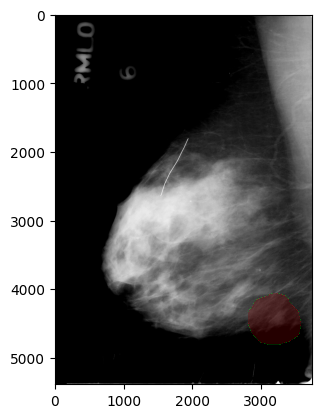

In [28]:
n = 1




annotated_image = ddsm_annotations.iloc[n]['original_path']
print(annotated_image)
image = Image.open(annotated_image)
print(image.size)
fig, ax = plt.subplots(1,1)
annotations = read_annotation_image(ddsm_annotations.iloc[n]['overlay_path'])

masks = []
for annotation in annotations:
    mask = create_abnormality_mask(np.array(image), annotation['outline'])
    
    print("Annotation: ", annotation)
    class_name = annotation['type'] + "_" + annotation['pathology']
    print("Class name: ", class_name, " ", class_to_idx[class_name] )
    
    mask = mask * (class_to_idx[class_name] )
    
    masks.append(mask)
    

mask = np.max(masks, axis=0)
ax.imshow(image, cmap='gray')

from matplotlib.colors import ListedColormap

colors = [(0, 0, 0, 0),    # Transparent for label 0
          (0, 1, 0, 0.6),  # Bright green with alpha
          (0, 0.5, 0, 0.6),# Dark green with alpha
          (1, 0, 0, 0.6),  # Bright red with alpha
          (0.5, 0, 0, 0.6)]# Dark red with alpha
cmap = ListedColormap(colors)


ax.imshow(mask, cmap=cmap, alpha=0.5)


In [41]:
n = 1
total = len(ddsm_annotations)
for n in range(1940, len(ddsm_annotations)):
    annotated_image = ddsm_annotations.iloc[n]['original_path']
    image = Image.open(annotated_image)
    
    
    annotations = read_annotation_image(ddsm_annotations.iloc[n]['overlay_path'])

    masks = []
    for annotation in annotations:
        mask = create_abnormality_mask(np.array(image), annotation['outline'])
        
        #print("Annotation: ", annotation)
        
        pathology = annotation['pathology']
        if pathology == 'BENIGN_WITHOUT_CALLBACK':
            pathology = 'BENIGN'
            
       
            
        if pathology == 'UNPROVEN':
            pathology = 'MALIGNANT'
        
        class_name = annotation['type'] + "_" + pathology
        #print("Class name: ", class_name, " ", class_to_idx[class_name] )
        
        if class_name == 'OTHER_BENIGN':
            continue
    
        if 'MASS_UNPROVEN' == class_name:
            class_name = 'MASS_BENIGN'  if annotation['breast_malignant']==False else 'MASS_MALIGNANT'
            #print("Changed MASS UNPROVEN to ", annotations.at[k, 'label'], " ", record['image_id'])
        if 'CALCIFICATION_UNPROVEN' == class_name:
            class_name = 'CALCIFICATION_BENIGN'  if annotation['breast_malignant']==False else 'CALCIFICATION_MALIGNANT'
            #print("Changed CALCIFICATION UNPROVEN to ", annotations.at[k, 'label'], " ", record['image_id'])

        
        
        mask = mask * (class_to_idx[class_name] )
        
        masks.append(mask)
        
    if len(masks) == 0:
        continue
    mask = np.max(masks, axis=0)
    
    mask_name = str(annotated_image).replace('.png', '_mask.png')
    mask_image = Image.fromarray(mask)
    
    print(f"{n}/{total} Saving mask: ", mask_name)
    
    

    


1940/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.LEFT_CC_mask.png
1941/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.RIGHT_MLO_mask.png
1942/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.LEFT_MLO_mask.png
1943/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.RIGHT_CC_mask.png
1944/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case0472/C_0472_1.RIGHT_CC_mask.png
1945/4029 Saving mask:  /media/HD/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case0451/C_0451_1.RIGHT_MLO_mask.png
[{'type': 'OTHER', 'assessment': 2, 'subtlety': 5, 'pathology': 'BENIGN_WITHOUT_CALLBACK', 'outline': (array([2952, 2952, 2953, ..., 2951, 2951, 2952]), array([3712, 3712, 3711, ..., 